In [1]:
!pip -q install ultralytics>=8.3.0 opencv-python cvzone onnx onnxruntime pyyaml

import os, glob, yaml, cv2, random, time, math
import numpy as np
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
# Upload Roboflow export zip (contains data.yaml + train/ valid/ test/)
from google.colab import files
uploaded = files.upload()
zip_path = next(iter(uploaded.keys()))
print("ZIP:", zip_path)

# Unzip to /content/datasets
!mkdir -p /content/datasets
!unzip -q "{zip_path}" -d /content/datasets

# Locate data.yaml
yamls = glob.glob("/content/datasets/**/data*.yaml", recursive=True)
assert yamls, "data.yaml not found in the ZIP. Open the ZIP to confirm it includes data.yaml."
DATA_YAML = yamls[0]
DATA_DIR  = os.path.dirname(DATA_YAML)
print("DATA_DIR :", DATA_DIR)
print("DATA_YAML:", DATA_YAML)

# Read class names
with open(DATA_YAML) as f:
    cfg = yaml.safe_load(f)
names = cfg["names"]
print("Classes:", names)

# Quick counts
def count_images(path): return len(glob.glob(os.path.join(path, "images", "*")))
print("train imgs:", count_images(os.path.join(DATA_DIR, "train")))
print("valid imgs:", count_images(os.path.join(DATA_DIR, "valid")))
print("test imgs :", count_images(os.path.join(DATA_DIR, "test")))


Saving ppe.v1i.yolov8.zip to ppe.v1i.yolov8.zip
ZIP: ppe.v1i.yolov8.zip
DATA_DIR : /content/datasets
DATA_YAML: /content/datasets/data.yaml
Classes: ['Gloves', 'Hard Hat', 'coverall']
train imgs: 1134
valid imgs: 327
test imgs : 157


In [3]:
from ultralytics import YOLO
import os, glob, torch

device = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = YOLO("yolov8n.pt")
model.train(
    data=DATA_YAML,
    epochs=30,
    imgsz=640,
    batch=8,
    workers=2,
    device=device,
    project="runs",
    name="ppe_yolov8n",
    exist_ok=True
)

# Best checkpoint → save as /content/ppe.pt
best_pt = "runs/ppe_yolov8n/weights/best.pt"
if not os.path.exists(best_pt):
    found = sorted(glob.glob("runs/**/weights/best.pt", recursive=True))
    assert found, "best.pt not found under runs/."
    best_pt = found[-1]

!cp "{best_pt}" /content/ppe.pt
print(f"Saved model → /content/ppe.pt (from {best_pt})")


Using device: 0
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ppe_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

In [4]:
from ultralytics import YOLO
import os, glob, yaml, torch

# reuse from your previous cells:
# DATA_YAML, DATA_DIR already set; /content/ppe.pt exists
device = 0 if torch.cuda.is_available() else "cpu"
model = YOLO("/content/ppe.pt")

# Validation split (Roboflow uses folder 'valid', but YAML maps it to 'val')
val_metrics  = model.val(data=DATA_YAML, split='val',  device=device, plots=True, save_json=True)
test_metrics = model.val(data=DATA_YAML, split='test', device=device, plots=True, save_json=True)
# (optional) training split metrics
# train_metrics = model.val(data=DATA_YAML, split='train', device=device, plots=True, save_json=True)

print("VAL:",  val_metrics.results_dict)    # mAP50, mAP50-95, precision, recall
print("TEST:", test_metrics.results_dict)

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1338.4±643.7 MB/s, size: 43.0 KB)
val: Scanning /content/datasets/valid/labels.cache... 327 images, 59 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 327/327 742.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 3.9it/s 5.4s
                   all        327        714      0.865      0.858      0.899      0.637
                Gloves        238        437      0.931      0.856      0.923      0.608
              Hard Hat        227        261       0.95      0.935       0.97      0.722
              coverall         10         16      0.714      0.782      0.803      0.581
Speed: 2.9ms preprocess, 5.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Saving /content/runs/detect/val/predictions.json...
R


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1134 /content/datasets/train/images/00000383_jpg.rf.0c05e8342270120bf5b70e80768f3e0f.jpg: 640x640 2 Hard Hats, 7.3ms
image 2/1134 /content/datasets/train/images/00000383_jpg.rf.692ed53c420a38e3b3009282dfe8b7b7.jpg: 640x640 2 Hard Hats, 7.6ms
image 3/1134 /content/datasets/train/images/00004_jpg.rf.7e779b2ff1f3c5e590c6c107ed45fd6d.jpg: 640x640 (no detections), 8.9ms
image 4/1134 /content/datasets/train/images/00022_jpg.rf.85ffebc1aacc1b63d1b45ca

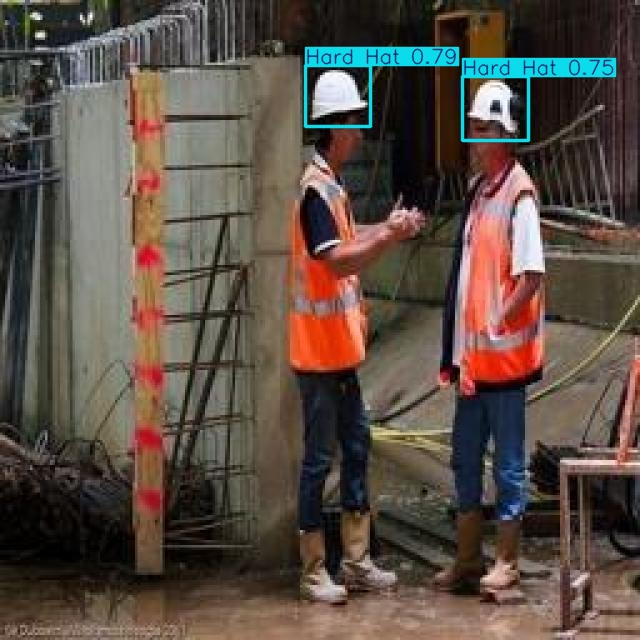

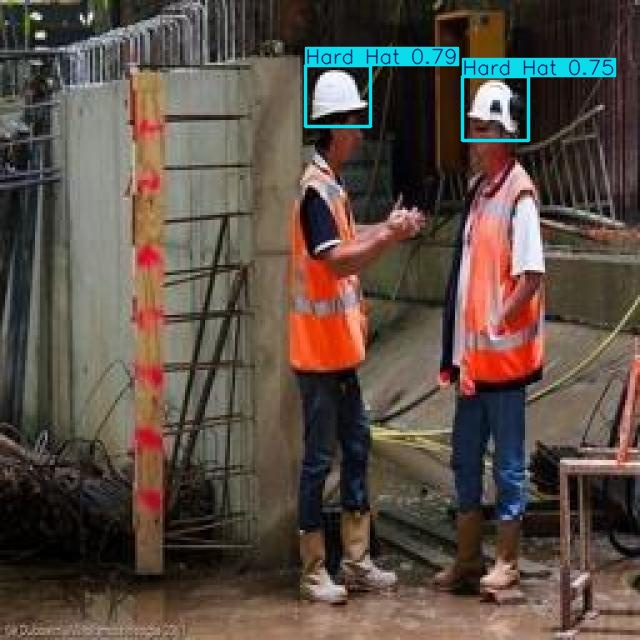

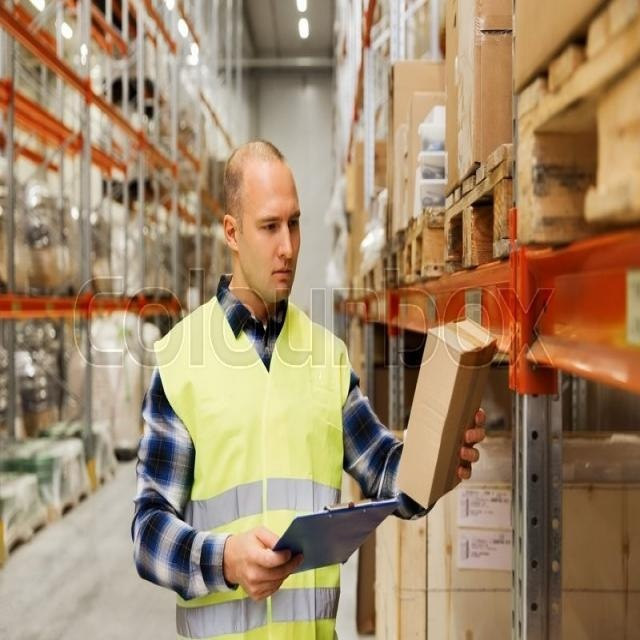

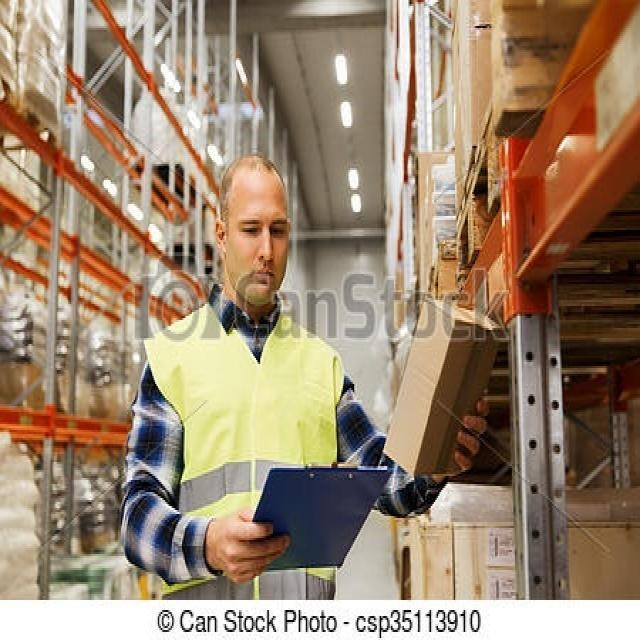

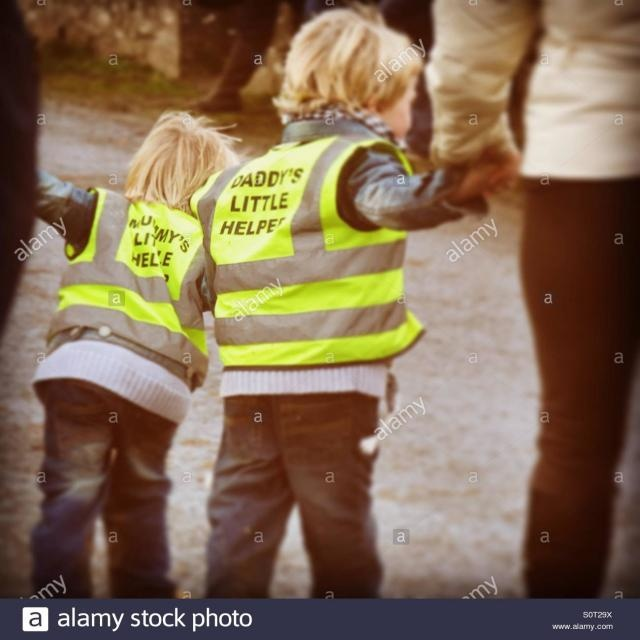

Saved predictions to: /content/preds/train

image 1/327 /content/datasets/valid/images/00011_jpg.rf.976fba6e42244157d94c3d9f35d999ba.jpg: 640x640 (no detections), 12.6ms
image 2/327 /content/datasets/valid/images/00014_jpg.rf.d13a43906e08c1ea7b307898c2e59ae9.jpg: 640x640 1 Hard Hat, 8.8ms
image 3/327 /content/datasets/valid/images/00100_jpg.rf.4a58796eba677c0e02ad8806fdbdec79.jpg: 640x640 1 Hard Hat, 1 coverall, 7.8ms
image 4/327 /content/datasets/valid/images/00113_jpg.rf.32744a2ac0d7b9deb3d56e24b7825f1e.jpg: 640x640 2 Hard Hats, 8.5ms
image 5/327 /content/datasets/valid/images/00131_jpg.rf.88a2dc84c0c26ce81e394dea40d983b6.jpg: 640x640 (no detections), 7.3ms
image 6/327 /content/datasets/valid/images/00190_jpg.rf.b7bee821093004eab54c30f073ef8a6b.jpg: 640x640 3 Hard Hats, 8.0ms
image 7/327 /content/datasets/valid/images/00224_jpg.rf.4207b660f7d7165ec335396966ed404e.jpg: 640x640 1 Gloves, 1 Hard Hat, 7.7ms
image 8/327 /content/datasets/valid/images/00248_jpg.rf.c5ee7d0651699d1899ee829a8

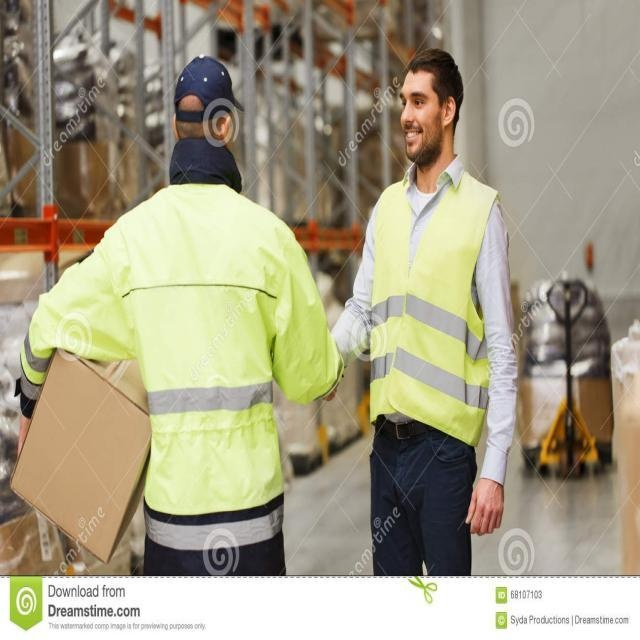

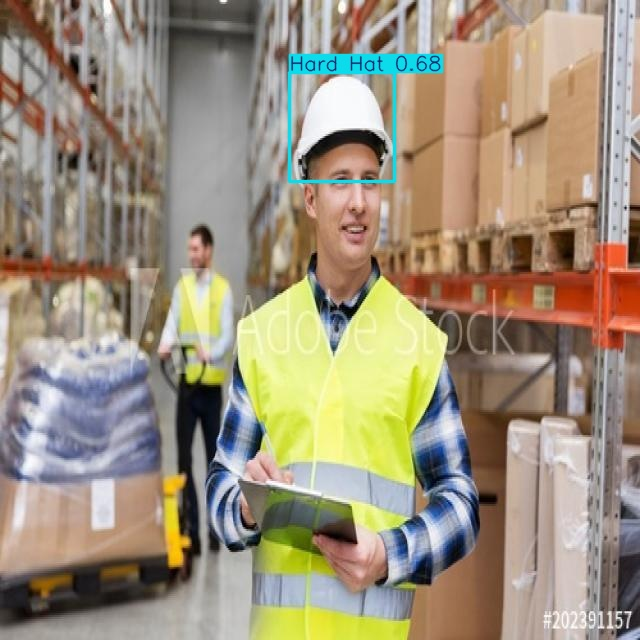

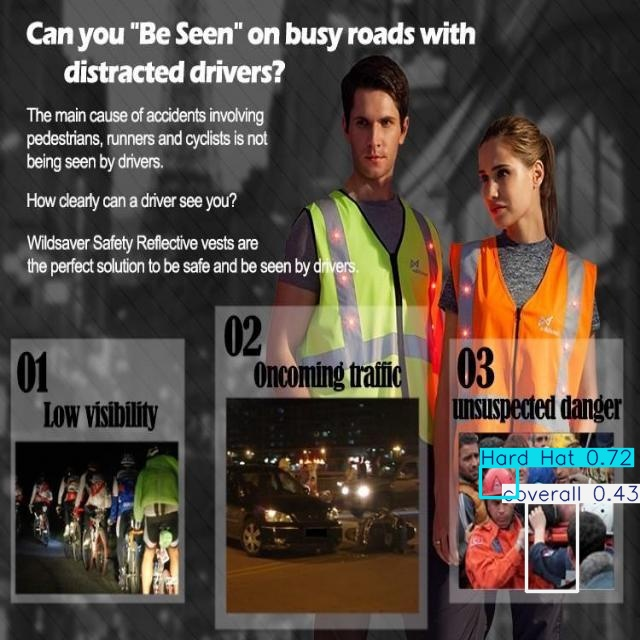

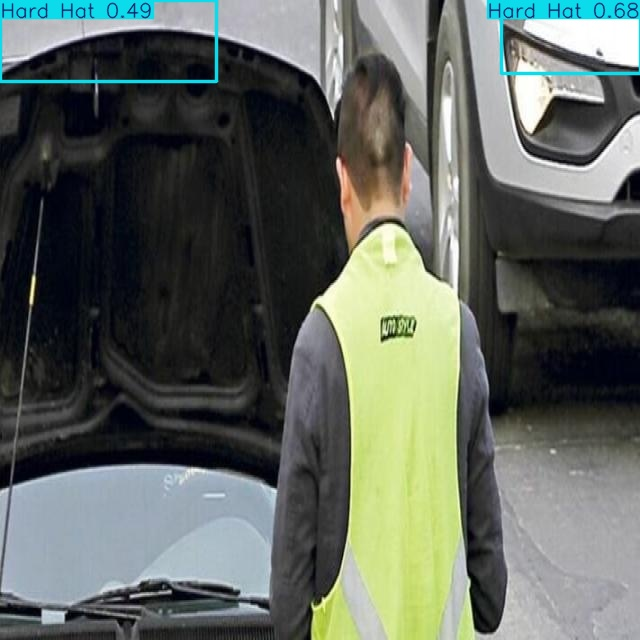

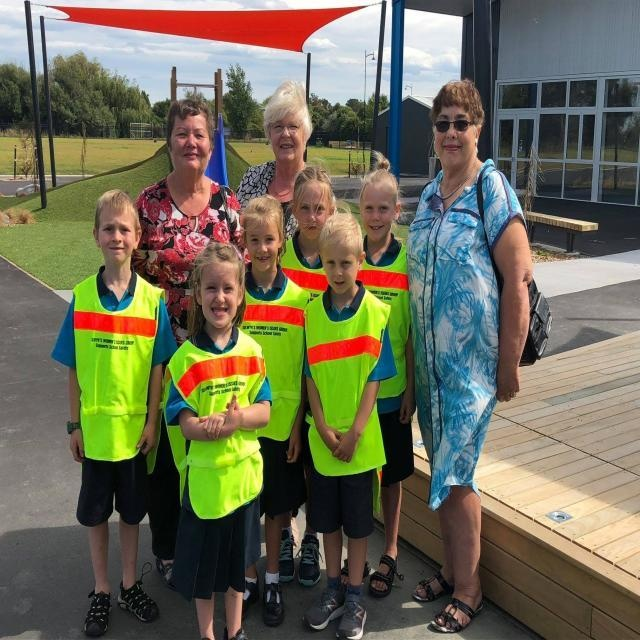

Saved predictions to: /content/preds/valid

image 1/157 /content/datasets/test/images/00107_jpg.rf.2f0a66e47d48134cddc597bf766ea513.jpg: 640x640 1 Hard Hat, 13.5ms
image 2/157 /content/datasets/test/images/00236_jpg.rf.9c170b36a6cba633316ff4cff97a2b2f.jpg: 640x640 (no detections), 10.8ms
image 3/157 /content/datasets/test/images/00275_jpg.rf.da48b6f54c75e560f284e44abfc9a5e9.jpg: 640x640 1 Hard Hat, 10.6ms
image 4/157 /content/datasets/test/images/00350_jpg.rf.352707103f962495cd8d69cc72a5b1d9.jpg: 640x640 1 Hard Hat, 10.5ms
image 5/157 /content/datasets/test/images/00486_jpg.rf.9587a8dba0aeb167d1f8cf40a369096e.jpg: 640x640 (no detections), 10.1ms
image 6/157 /content/datasets/test/images/00852_jpg.rf.718409beeddaaefff4f4e8cdb28d79e5.jpg: 640x640 1 Gloves, 8.0ms
image 7/157 /content/datasets/test/images/101_JPG_jpg.rf.2b5e7ee7b8472f4e5bc95f94cddd87c1.jpg: 640x640 1 Hard Hat, 11.8ms
image 8/157 /content/datasets/test/images/109_JPG_jpg.rf.5e72eb3cf6ef3ac6f8dc93425ff5503f.jpg: 640x640 3 Gl

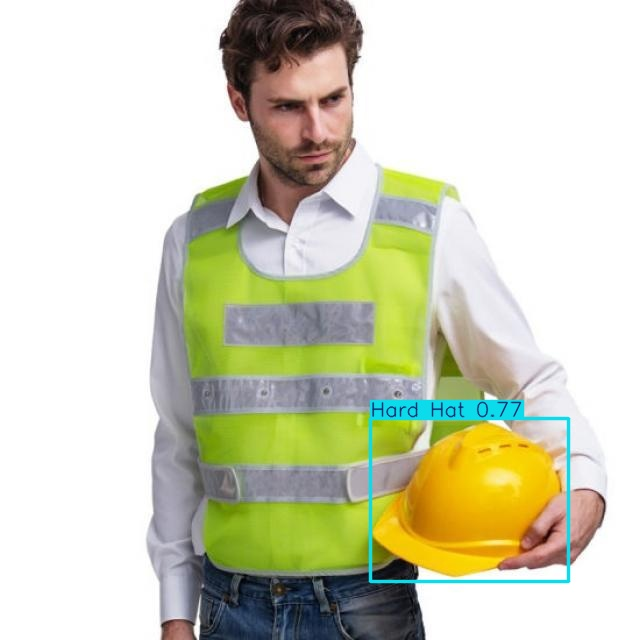

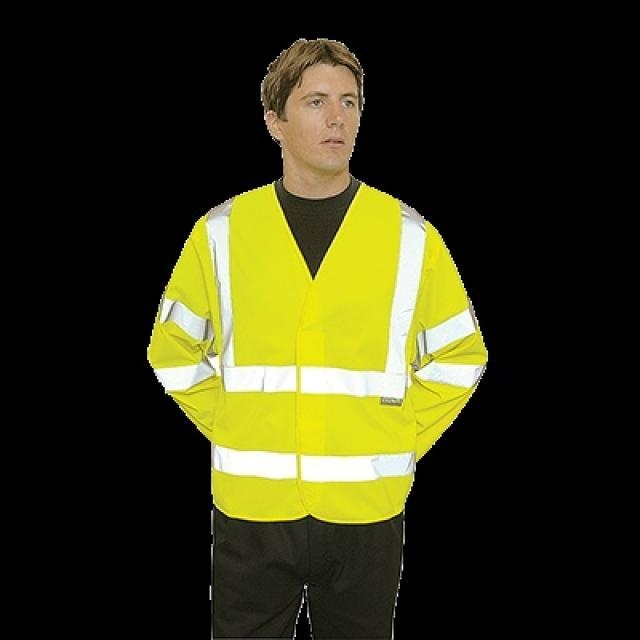

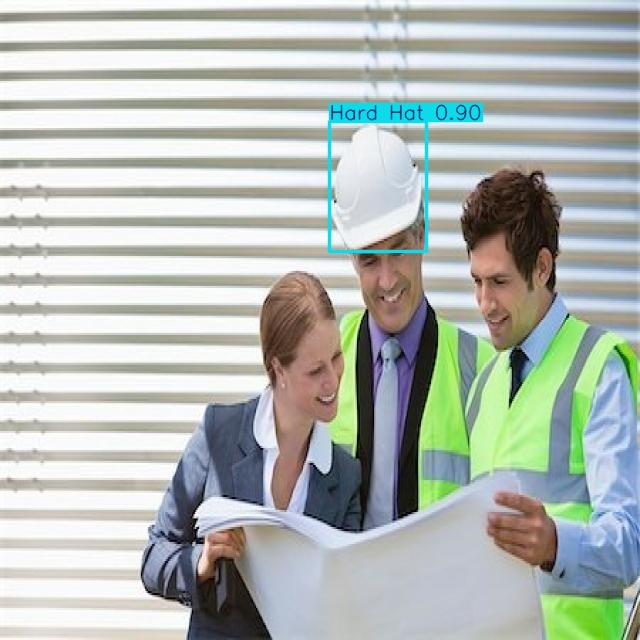

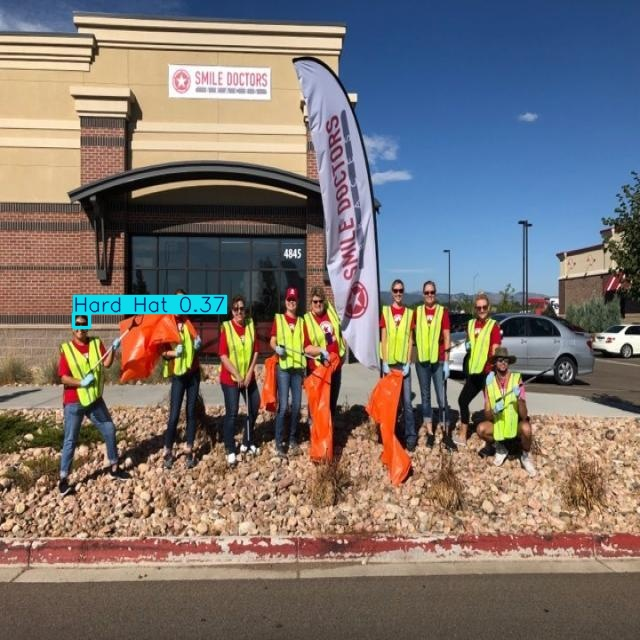

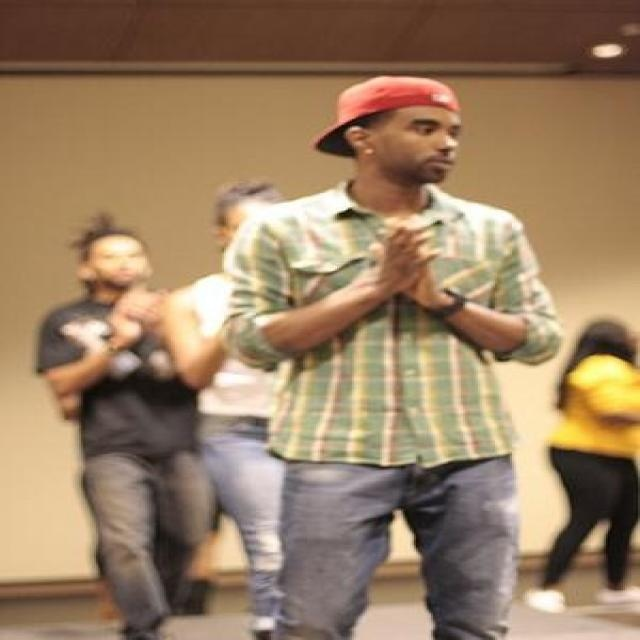

Saved predictions to: /content/preds/test


In [5]:
from ultralytics import YOLO
import os, glob
from IPython.display import display, Image as IPyImage

pred_root = "/content/preds"
model = YOLO("/content/ppe.pt")

for split in ["train", "valid", "test"]:
    src = os.path.join(DATA_DIR, split, "images")
    if not os.path.isdir(src):
        continue
    model.predict(
        source=src,
        conf=0.35, iou=0.5,
        save=True, save_txt=True, save_conf=True,   # images + YOLO txt predictions
        project=pred_root, name=split, exist_ok=True,
        device=device, max_det=300
    )
    # Preview a few annotated images
    out_dir = f"{pred_root}/{split}"
    imgs = sorted(glob.glob(f"{out_dir}/*.[jp][pn]g"))[:5]
    for p in imgs:
        display(IPyImage(filename=p))
    print(f"Saved predictions to: {out_dir}")

In [6]:
import pandas as pd

rows = []
for split in ["train","valid","test"]:
    lbl_dir = f"{pred_root}/{split}/labels"
    if not os.path.isdir(lbl_dir):
        continue
    for f in glob.glob(f"{lbl_dir}/*.txt"):
        img_stem = os.path.splitext(os.path.basename(f))[0]
        with open(f) as fh:
            for ln in fh:
                parts = ln.strip().split()
                if len(parts) < 6:
                    continue
                cls = int(parts[0]); cx,cy,w,h,conf = map(float, parts[1:6])
                rows.append(dict(split=split, image=img_stem, cls_id=cls, conf=conf, cx=cx, cy=cy, w=w, h=h))
df = pd.DataFrame(rows)
df.head(10)

,split,image,cls_id,conf,cx,cy,w,h
0,train,Image_ipg-1958-_jpg.rf.d07c240e21d6705bc425364...,0,0.759729,0.656974,0.221299,0.148616,0.113289
1,train,Image_ipg-1958-_jpg.rf.d07c240e21d6705bc425364...,1,0.758154,0.479416,0.162729,0.174930,0.090178
2,train,Image_ipg-1958-_jpg.rf.d07c240e21d6705bc425364...,0,0.653552,0.267702,0.217551,0.128957,0.112860
3,train,Aitin1378_jpg.rf.fc8eac96c3e08e06c999113c2027a7d7,1,0.860431,0.440379,0.256295,0.045218,0.090386
4,train,Aitin1378_jpg.rf.fc8eac96c3e08e06c999113c2027a7d7,1,0.848219,0.879138,0.350845,0.050941,0.075427
5,train,Aitin1378_jpg.rf.fc8eac96c3e08e06c999113c2027a7d7,1,0.807214,0.332452,0.208783,0.044999,0.090372
6,train,Aitin1378_jpg.rf.fc8eac96c3e08e06c999113c2027a7d7,1,0.804210,0.188663,0.096439,0.073490,0.073650
7,train,Aitin1378_jpg.rf.fc8eac96c3e08e06c999113c2027a7d7,1,0.794320,0.714467,0.202497,0.041554,0.072255
8,train,Aitin1378_jpg.rf.fc8eac96c3e08e06c999113c2027a7d7,1,0.787823,0.568256,0.291472,0.041277,0.061155
9,train,Aitin1378_jpg.rf.fc8eac96c3e08e06c999113c2027a7d7,0,0.710661,0.647111,0.515231,0.021020,0.069026
